# Anomaly Detection With Discord Discovery

This <a href="http://tylermarrs.com/posts/anomaly-detection-matrix-profile-discords/">notebook</a> is recreated.  
It shows how you can find discords within a matrix profile using a <a href="https://www.kaggle.com/boltzmannbrain/nab">NYC Taxi dataset from NAB dataset</a>.    

# Load Libraries

In [1]:
from matrixprofile import *
from matrixprofile.discords import discords
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

# Load Data from <a href='https://github.com/numenta/NAB/tree/master/data/realKnownCause'>NAB dataset's nyc_taxi.csv</a>

In [2]:
df = pd.read_csv('02_nyc_taxi.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').sort_index()

In [3]:
df.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


In [4]:
df.tail()

,value
timestamp,
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309
2015-01-31 23:00:00,26591
2015-01-31 23:30:00,26288


In [5]:
df.dtypes

value    int64
dtype: object

In [6]:
print('target time      taxi_count', len(df))
print('target time passenger_count', df.sum())

target time      taxi_count 10320
target time passenger_count value    156219716
dtype: int64


# Resample Data to Hour from 30min

In [7]:
df = df.resample('1H').sum()

In [8]:
df.head()

,value
timestamp,
2014-07-01 00:00:00,18971
2014-07-01 01:00:00,10866
2014-07-01 02:00:00,6693
2014-07-01 03:00:00,4433
2014-07-01 04:00:00,4379


In [9]:
df.tail()

,value
timestamp,
2015-01-31 19:00:00,56577
2015-01-31 20:00:00,48276
2015-01-31 21:00:00,48389
2015-01-31 22:00:00,53030
2015-01-31 23:00:00,52879


# Calculate Matrix Profile

In [10]:
a = df.values.squeeze()

# subsequence length to compute the matrix profile
# since we have hourly measurements and want to find daily events,
# we will create a length of 24 - number of hours in a day
m = 24
profile = matrixProfile.stomp(a,m)
df['profile'] = np.append(profile[0],np.zeros(m-1)+np.nan)
df['profile_index'] = np.append(profile[1], np.zeros(m - 1) + np.nan)
df.head()

,value,profile,profile_index
timestamp,,,
2014-07-01 00:00:00,18971,0.391013,504.0
2014-07-01 01:00:00,10866,0.394675,505.0
2014-07-01 02:00:00,6693,0.399349,506.0
2014-07-01 03:00:00,4433,0.402701,507.0
2014-07-01 04:00:00,4379,0.405364,508.0


# Visualize Matrix Profile

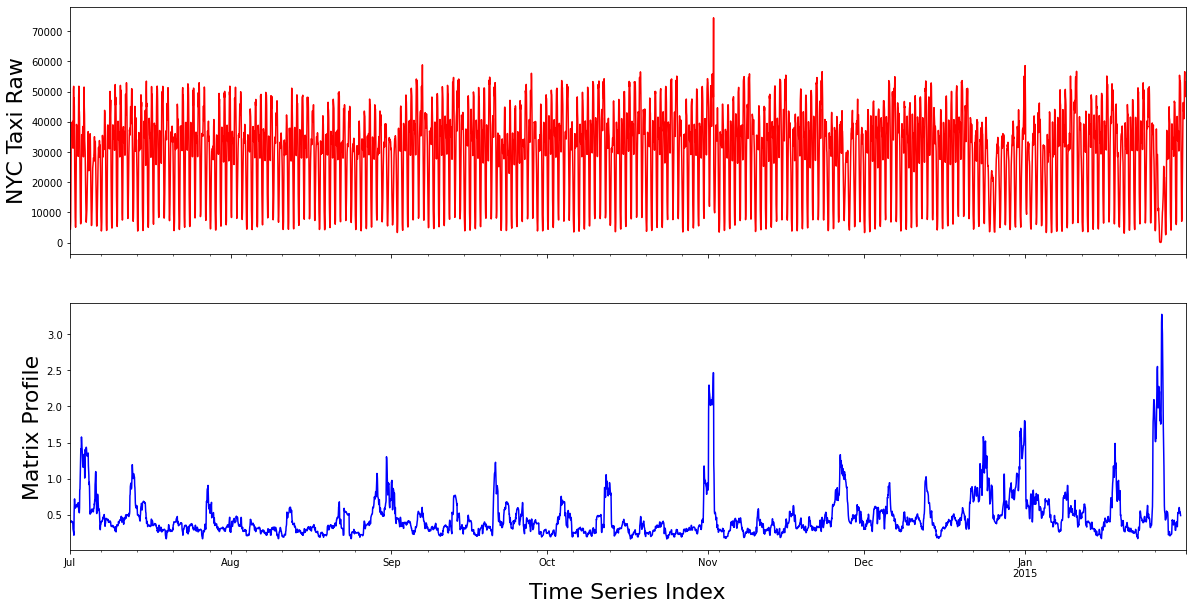

In [11]:
#Plot the signal data
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(20,10))
df['value'].plot(ax=ax1, kind='line', c='r')
ax1.set_ylabel('NYC Taxi Raw', size=22)

#Plot the Matrix Profile
df['profile'].plot(ax=ax2, kind='line', c='b')
ax2.set_ylabel('Matrix Profile', size=22)
ax2.set_xlabel('Time Series Index', size=22)

plt.savefig('02_NYC_Taxi_MP.png', bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [12]:
from matrixprofile.discords import discords
# exclude up to a day on the left and right side
ex_zone = 12

# we look for the 5 events specified in the data explaination
anoms = discords(df['profile'], ex_zone, k=15)
anoms

array([5049, 5029, 2976, 2956, 5012, 4415, 4397, 4224,   55, 4833,   77,
       3563, 4240, 1465, 1969])

In [13]:
df_anoms = df.iloc[anoms].sort_values(by='profile', ascending=False)
df_anoms

,value,profile,profile_index
timestamp,,,
2015-01-27 09:00:00,3874,3.275818,129.0
2015-01-26 13:00:00,29149,2.553384,4837.0
2014-11-02 00:00:00,48219,2.468237,2304.0
2014-11-01 04:00:00,25618,2.295825,4132.0
2015-01-25 20:00:00,29503,2.094151,4824.0
2014-12-31 23:00:00,35978,1.803195,4653.0
2014-12-31 05:00:00,5090,1.697118,4611.0
2014-12-24 00:00:00,20646,1.581157,1466.0
2014-07-03 07:00:00,26814,1.576729,2166.0


# Compare [5 known anomalies] vs [Matrix Profile Result]

5 known anomalies of the number of taxi passengers from 2014-07-01 to 2015-01-31.  

* NYC Marathon - 2014-11-02
* Thanksgiving - 2014-11-27
* Christmas - 2014-12-25
* New Years - 2015-01-01
* Snow Blizzard - 2015-01-26 and 2015-01-27

# This [Matrix Profile Result] is better than 5 known anomalies.

Snow Blizzard - 2015-01-26 ~ 27  
Christmas     - 2014-12-24
New Years     - 2014-12-31  
???           - 2014-07-03 ~ 04  
<a href='https://www.pressreader.com/usa/new-york-daily-news/20140703/textview'>What happend in NYC daily news on 2014-07-03 ?</a>

In [14]:
mask_snow_blizard = ('2015-01-26 00:00:00' <= df_anoms.index) & (df_anoms.index <= '2015-01-27 23:59:00')
mask_new_years = ('2014-12-31 00:00:00' <= df_anoms.index) & (df_anoms.index <= '2014-12-31 23:59:00')
mask_xxx = ('2014-07-03 00:00:00' <= df_anoms.index) & (df_anoms.index <= '2014-07-04 23:59:00')
df_anoms[mask_snow_blizard + mask_new_years + mask_xxx].sort_index(ascending=True)

,value,profile,profile_index
timestamp,,,
2014-07-03 07:00:00,26814,1.576729,2166.0
2014-07-04 05:00:00,6735,1.434912,4301.0
2014-12-31 05:00:00,5090,1.697118,4611.0
2014-12-31 23:00:00,35978,1.803195,4653.0
2015-01-26 13:00:00,29149,2.553384,4837.0
2015-01-27 09:00:00,3874,3.275818,129.0


# Fast predict for secure golden time.
The above including a result from matrixprofile and a unproven hypothesis.  
Not focus on correlation and causation.

# Data exploration
https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration

# Compare Random Cut Forest
https://aws.amazon.com/ko/blogs/korea/use-the-built-in-amazon-sagemaker-random-cut-forest-algorithm-for-anomaly-detection/